# Projet IA Frameworks 2023 - Partie 1

@nestorhabibi
@julien-blanchon
@XuanMinhVuongNGUYEN

Dans ce projet, vous allez travailler sur des données<sup>[1](#myfootnote1)</sup> issues du site [Food.com](https://www.food.com/), un célèbre site de recettes de cuisine.   

![Image food](../img/food.png)

Les données, disponibles [ici](https://drive.google.com/drive/folders/18JyoxTIrIH2s2wG6HtxGiKsdFtGSfUWm?usp=sharing), contiennent des informations sur des recettes de cuisines ainsi que des interactions de plusieurs utilisateurs avec les recettes.   


> Dans __un notebook__
> *   Présentez plusieurs stratégies de recommandation  de recettes:
> *   Par popularité
> *   Selon les étapes de la recette (colonne steps)
> *   Selon la description de la recette 
> 
> Pour chacune de ces méthodes montrez quelques exemples des recommandation  obtenues.

## Partie 0: Librairies, Données et Exploration

### 0.0 Librairies et Données

Librairies utilisées :

In [2]:
# data
import pandas as pd
import numpy as np

# plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# machine learning
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
import scipy

# NLP
from nltk import word_tokenize          
from nltk.stem import SnowballStemmer
import nltk
from nltk.corpus import stopwords

# display
from IPython.display import display, HTML

# typing
from typing_extensions import Literal, Self, override
from typing import Optional, Any, Iterable

In [3]:
sns.set_style('white')
# plt.xkcd()
mpl.rcParams['font.family'] = ['DejaVu Sans']

Ouverture des données :

In [4]:
interactions_train = pd.read_csv('../data/interactions_train.csv') # user to train recommender 
interactions_test = pd.read_csv('../data/interactions_test.csv') # used to predict the ratings

raw_interactions = pd.read_csv('../data/RAW_interactions.csv') # sentiment analysis
raw_recipes = pd.read_csv('../data/RAW_recipes.csv') # used for recommender

test_script = pd.read_csv('../data/test_script.csv') 

print(f"There is a total of {interactions_train.shape[0]} interactions and {raw_recipes.shape[0]} recipes")

print(f"Train data: {interactions_train.shape[0]}")
print(f"Test data: {interactions_test.shape[0]}")

There is a total of 698901 interactions and 231637 recipes
Train data: 698901
Test data: 12455


In [5]:
name_description_ingredient = (
    raw_recipes["name"] + " " \
    + raw_recipes["description"] + " " \
    + raw_recipes["ingredients"]
)

In [6]:
raw_recipes.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


### 0.1 Exploration

#### a. Quelques statistiques descriptives

In [7]:
# Get all unique user ids from train and test
train_users = interactions_train['user_id'].unique()
test_users = interactions_test['user_id'].unique()

# concatenate users and return unique values
all_users = np.unique(np.concatenate((train_users, test_users), axis=0))

# Get all unique recipe ids from train and test
train_recipes = interactions_train['recipe_id'].unique()
test_recipes = interactions_test['recipe_id'].unique()

# concatenate recipes and return unique values
all_recipes = np.unique(np.concatenate((train_recipes, test_recipes), axis=0))

print('Number of unique users: {}'.format(len(all_users)))
print('Number of unique recipes: {}'.format(len(all_recipes)))

Number of unique users: 25076
Number of unique recipes: 172596


In [8]:
# compute value counts of recipes
recipe_counter = interactions_train['recipe_id'].value_counts()
# most_common_recipe = recipe_counter.idxmax()
# most_common_recipe_count = recipe_counter.max()

# print the 5 most popular recipes and their name
top_10_recipes = recipe_counter[:5]
top_10_recipe_ids = top_10_recipes.index
top_10_recipe_counts = top_10_recipes.values

print('Top 5 recipes:')
for i in range(5):
    print('Recipe id: {}'.format(top_10_recipe_ids[i]))
    print('Number of times it appears: {}'.format(top_10_recipe_counts[i]))
    print('Average rating: {}'.format(
        interactions_train.query(f'recipe_id == @top_10_recipe_ids[{i}]')["rating"].mean()
        )
    )
    print('Recipe name: {}'.format(
        raw_recipes.query(f'id == @top_10_recipe_ids[{i}]')["name"].values[0]
        )
    )
    print()

Top 5 recipes:
Recipe id: 27208
Number of times it appears: 1091
Average rating: 4.413382218148487
Recipe name: to die for crock pot roast

Recipe id: 89204
Number of times it appears: 1075
Average rating: 4.346976744186047
Recipe name: crock pot chicken with black beans   cream cheese

Recipe id: 32204
Number of times it appears: 897
Average rating: 4.608695652173913
Recipe name: whatever floats your boat  brownies

Recipe id: 39087
Number of times it appears: 894
Average rating: 4.691275167785235
Recipe name: creamy cajun chicken pasta

Recipe id: 69173
Number of times it appears: 787
Average rating: 4.777636594663278
Recipe name: kittencal s italian melt in your mouth meatballs



Text(0, 0.5, 'Density')

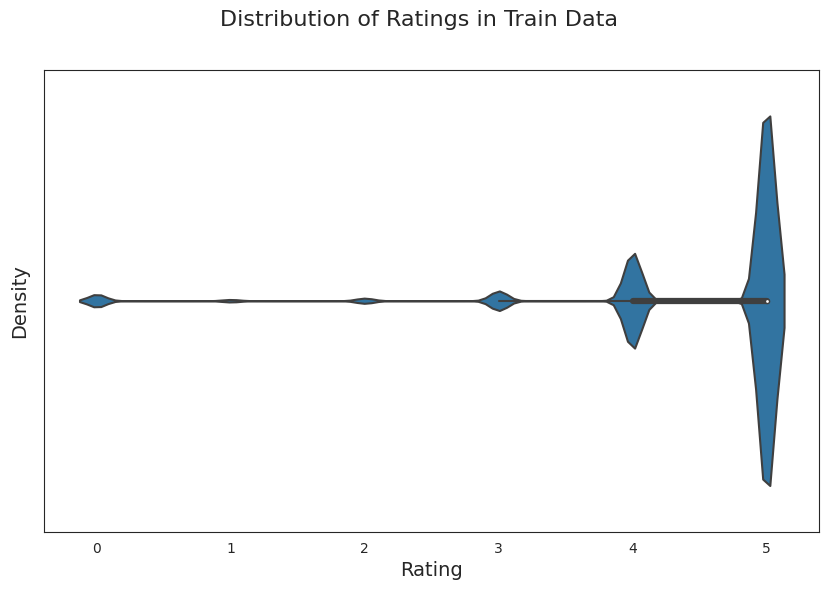

In [9]:
# Violin plot of ratings
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Distribution of Ratings in Train Data', fontsize=16)

sns.violinplot(
    x='rating',
    data=interactions_train,
    ax=ax
)
ax.set_xlabel('Rating', fontsize=14)
ax.set_ylabel('Density', fontsize=14)

### 0.2 Classe recommandation

In [10]:
from abc import ABC, abstractmethod

class RecommendationSystem(ABC):
    """Abstract class for recommendation systems

    Raises
    ------
    NotImplementedError
        If the method is not implemented
    """

    @abstractmethod
    def fit(self, interactions_train: pd.DataFrame, raw_recipes: pd.DataFrame):
        """Fit the recommander system to the data.
        Could use:
        - Only interactions_train
        - Only raw_recipes
        - Both

        Parameters
        ----------
        interactions_train : pd.DataFrame
            Interactions between users and recipes
        raw_recipes : pd.DataFrame
            Recipes extra data (name, description, ingredients, ...)
        """
        raise NotImplementedError
    
    @abstractmethod
    def predict(self, k: int, query: Any) -> list[int]:
        """Predict the k best recipes for a given user according to this recommendation system.

        Parameters
        ----------
        k : int
            Number of recipes to recommend.
        query : Any
            Query to use to predict the recipes.

        Returns
        -------
        list[int]
            List of top-k recipes ids.
        
        """
        raise NotImplementedError

In [11]:
interactions_train.head()

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


## Partie 1 : Système de recommendation simple

### 1.1 Système de recommandation non personnalisé - Recommendation par popularité

Les système de recommandation non personnalisé se basent sur des statistiques agrégées et ne prennent pas en considération les préférences ou comportements individuels des utilisateurs.

Dans cette partie, nous examinerons quatre méthodes essentielles de recommandation non personnalisée:

1. **Moyenne ("Average")**: Cette stratégie repose sur la recommandation d'articles qui ont reçu les notes les plus élevées en moyenne.L'idée fondamentale est que *les articles ayant reçu une appréciation générale positive ont une probabilité plus élevée d'être appréciés par un large éventail d'utilisateurs*.

2. **Quantité ("Count")**: Cette méthode met l'accent sur la popularité des articles, mesurée par leur nombre total de votes ou d'évaluations. L'idée fondamentale est que si *un article a été fréquemment sélectionné ou noté positivement, il est susceptible d'être un choix pertinent pour d'autres utilisateurs*.

3. **Moyenne pondérée ("Weighted Average")**: Cette approche vise à amalgamer les deux premières méthodes en attribuant des poids aux scores moyens et aux comptes pour obtenir une métrique de recommandation plus robuste et équilibrée.

4. **IMDB**: Cette méthode s'inspire de la formule utilisée par la base de données de films en ligne IMDB pour classer les films. Elle intègre la note moyenne d'un article et le nombre de votes qu'il a reçus pour produire un score de recommandation composite.




| Méthode | Avantages | Inconvénients |
| --- | --- | --- |
| **Average** | Simplicité, point de départ solide | Ignorance du nombre de votes |
| **Count** | Réactive à la popularité, simple | Ignorance de la qualité |
| **Weighted Average** | Équilibrée (qualité + popularité) | Détermination des poids, ignorance des préférences utilisateurs |
| **IMDB** | Équilibrée (qualité + popularité) + normalisée | Complexité de paramétrage, ignorance des préférences utilisateurs |


In [12]:
class RecommendationPopularity(RecommendationSystem):
    """Recommendation system based on popularity
    """
    def __init__(self, method: Literal["average", "count", "weighted_average", "imdb"] = "average", m: Optional[int] = None):
        super(RecommendationSystem, self).__init__()
        self.method = method
        self._sorted_recipes: list[int]
        if method != "imdb" and m is not None:
            raise ValueError("m can only be set for method imdb")
        self.m = m

    def _fit_average(self, interactions_train: pd.DataFrame, raw_recipes: pd.DataFrame) -> Self:
        """Fit the popularity model using the average rating of the recipes

        Parameters
        ----------
        interactions_train : pd.DataFrame
            Interactions between users and recipes.
        raw_recipes : pd.DataFrame
            Recipes extra data (name, description, ingredients, ...), not used.

        Returns
        -------
        Self
        """
        recipe_avg = interactions_train.groupby('recipe_id')['rating'].mean()
        sorted_recipes_avg_id = recipe_avg.sort_values(ascending=False).index.to_list()
        self._sorted_recipes = sorted_recipes_avg_id
        return self
    
    def _fit_count(self, interactions_train: pd.DataFrame, raw_recipes: pd.DataFrame) -> Self:
        """Fit the popularity model using the number of ratings of the recipes

        Parameters
        ----------
        interactions_train : pd.DataFrame
            Interactions between users and recipes.
        raw_recipes : pd.DataFrame
            Recipes extra data (name, description, ingredients, ...), not used.

        Returns
        -------
        Self
        """
        recipe_count = interactions_train.groupby('recipe_id')['rating'].count()
        sorted_recipes_count = recipe_count.sort_values(ascending=False).index.to_list()
        self._sorted_recipes = sorted_recipes_count
        return self
    
    def _fit_weighted_average(self, interactions_train: pd.DataFrame, raw_recipes: pd.DataFrame) -> Self:
        """Fit the popularity model using the weighted average of the recipes

        Parameters
        ----------
        interactions_train : pd.DataFrame
            Interactions between users and recipes.
        raw_recipes : pd.DataFrame
            Recipes extra data (name, description, ingredients, ...), not used.

        Returns
        -------
        Self
        """
        recipe_avg = interactions_train.groupby('recipe_id')['rating'].mean()
        recipe_count = interactions_train.groupby('recipe_id')['rating'].count()
        recipe_weighted_avg = recipe_avg * np.log10(recipe_count + 1)
        sorted_recipes_weighted_avg = recipe_weighted_avg.sort_values(ascending=False).index.to_list()
        self._sorted_recipes = sorted_recipes_weighted_avg
        return self
    
    def _fit_imdb(self, interactions_train: pd.DataFrame, raw_recipes: pd.DataFrame) -> Self:
        """Fit the popularity model using the IMDB formula

        Parameters
        ----------
        interactions_train : pd.DataFrame
            Interactions between users and recipes.
        raw_recipes : pd.DataFrame
            Recipes extra data (name, description, ingredients, ...), not used.

        Returns
        -------
        Self
        """
        # R
        recipe_avg = interactions_train.groupby('recipe_id')['rating'].mean()
        # v
        recipe_count = interactions_train.groupby('recipe_id')['rating'].count()
        # C
        recipe_global_mean = interactions_train['rating'].mean()
        
        recipe_imdb = (
            (recipe_count / (recipe_count + self.m)) * recipe_avg \
                + (self.m / (recipe_count + self.m)) * recipe_global_mean
        )
        sorted_recipe_imdb = recipe_imdb.sort_values(ascending=False).index.to_list()
        self._sorted_recipes = sorted_recipe_imdb
        return self

    @override
    def fit(self, interactions_train: pd.DataFrame, raw_recipes: pd.DataFrame) -> Self:
        """Fit the popularity model using the given method

        Parameters
        ----------
        interactions_train : pd.DataFrame
            Interactions between users and recipes.
        raw_recipes : pd.DataFrame
            Recipes extra data (name, description, ingredients, ...), not used
            for popularity based methods.

        Returns
        -------
        Self

        Raises
        ------
        ValueError
            If the method is unknown.
        """
        if self.method == "average":
            return self._fit_average(interactions_train, raw_recipes)
        elif self.method == "count":
            return self._fit_count(interactions_train, raw_recipes)
        elif self.method == "weighted_average":
            return self._fit_weighted_average(interactions_train, raw_recipes)
        elif self.method == "imdb":
            return self._fit_imdb(interactions_train, raw_recipes)
        else:
            raise ValueError(f"Unknown method {self.method}")
    
    @override
    def predict(self, k: int, query: None = None) -> list[int]:
        """Predict the k best recipes for a given user according to this recommendation system.

        Parameters
        ----------
        k : int
            Number of recipes to recommend.
        query : None, optional
            Query to use to predict the recipes, by default None.
            For popularity based methods, the query is not used as the
            recommendation is the same for all users.

        Returns
        -------
        list[int]
            _description_
        """
        return self._sorted_recipes[:k]

In [13]:
recommandation_popularity = RecommendationPopularity(method="average")
recommandation_popularity.fit(interactions_train, raw_recipes)
recommanded_ids = recommandation_popularity.predict(5)

print('Top 5 recipes by average popularity:')
print('-----------------------------------')
for recommanded_id in recommanded_ids:
    interaction = interactions_train.query("recipe_id == @recommanded_id")
    raw = raw_recipes.query("id == @recommanded_id")
    print(f'Recipe id: {recommanded_id}')
    print(f'Average rating: {interaction["rating"].mean():0.4f}')
    print(f'Recipe name: {raw["name"].values[0]}')
    print()

Top 5 recipes by average popularity:
-----------------------------------
Recipe id: 537458
Average rating: 5.0000
Recipe name: garlic and herb mashed potatoes

Recipe id: 123184
Average rating: 5.0000
Recipe name: morris family s cheese ball

Recipe id: 123217
Average rating: 5.0000
Recipe name: lemon linguini with chicken

Recipe id: 123209
Average rating: 5.0000
Recipe name: cinnamon biscuits

Recipe id: 283775
Average rating: 5.0000
Recipe name: almond roasted duck with chinese spices



In [14]:
recommandation_popularity = RecommendationPopularity(method="count")
recommandation_popularity.fit(interactions_train, raw_recipes)
recommanded_ids = recommandation_popularity.predict(5)

print('Top 5 recipes by number of rating popularity:')
print('--------------------------------------------')
print()
for recommanded_id in recommanded_ids:
    interaction = interactions_train.query("recipe_id == @recommanded_id")
    raw = raw_recipes.query("id == @recommanded_id")
    print(f'Recipe id: {recommanded_id}')
    print(f'Average rating: {interaction["rating"].mean():0.4f}')
    print(f'Recipe name: {raw["name"].values[0]}')
    print()

Top 5 recipes by number of rating popularity:
--------------------------------------------

Recipe id: 27208
Average rating: 4.4134
Recipe name: to die for crock pot roast

Recipe id: 89204
Average rating: 4.3470
Recipe name: crock pot chicken with black beans   cream cheese

Recipe id: 32204
Average rating: 4.6087
Recipe name: whatever floats your boat  brownies

Recipe id: 39087
Average rating: 4.6913
Recipe name: creamy cajun chicken pasta

Recipe id: 69173
Average rating: 4.7776
Recipe name: kittencal s italian melt in your mouth meatballs



Disadvantages of previous methods: 
- **Average rating**: recipes with only one five star review have an average of five. However, the review could have been made by a person who has very specific taste and loves the recipe.
- **Number of ratings**: recipes might appear a lot but not for a good reason. For example, a carbonara recipe with cream might get a lot of negative reviews from Italians.

Therefore, another method that combines average ratings and number of ratings should be implemented. 

For example, we can add the following information:


In [15]:
recommandation_popularity = RecommendationPopularity(method="weighted_average")
recommandation_popularity.fit(interactions_train, raw_recipes)
recommanded_ids = recommandation_popularity.predict(5)

print('Top 5 recipes by weighted average:')
print('----------------------------------')
print()
for recommanded_id in recommanded_ids:
    interaction = interactions_train.query("recipe_id == @recommanded_id")
    raw = raw_recipes.query("id == @recommanded_id")
    print(f'Recipe id: {recommanded_id}')
    print(f'Average rating: {interaction["rating"].mean():0.4f}')
    print(f'Recipe name: {raw["name"].values[0]}')
    print()

Top 5 recipes by weighted average:
----------------------------------

Recipe id: 39087
Average rating: 4.6913
Recipe name: creamy cajun chicken pasta

Recipe id: 69173
Average rating: 4.7776
Recipe name: kittencal s italian melt in your mouth meatballs

Recipe id: 32204
Average rating: 4.6087
Recipe name: whatever floats your boat  brownies

Recipe id: 27208
Average rating: 4.4134
Recipe name: to die for crock pot roast

Recipe id: 28148
Average rating: 4.7147
Recipe name: oven fried chicken chimichangas



Pour donner des recommendations en tenant compte de la popularité de la recette nous allons utiliser la formule inspirée du modèle de classement des films imbd décrit de la façon suivante : 
 [here](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#)  
![](https://drive.google.com/uc?export=view&id=12J_uJ86eOimr8Y0LHTGSMmUgkBnZu9cO)   

In [16]:
recommandation_popularity = RecommendationPopularity(method="imdb", m = 50)
recommandation_popularity.fit(interactions_train, raw_recipes)
recommanded_ids = recommandation_popularity.predict(5)

print('Top 5 recipes by imdb:')
print('----------------------')
print()
for recommanded_id in recommanded_ids:
    interaction = interactions_train.query("recipe_id == @recommanded_id")
    raw = raw_recipes.query("id == @recommanded_id")
    print(f'Recipe id: {recommanded_id}')
    print(f'Average rating: {interaction["rating"].mean():0.4f}')
    print(f'Recipe name: {raw["name"].values[0]}')
    print()

Top 5 recipes by imdb:
----------------------

Recipe id: 113299
Average rating: 4.9077
Recipe name: peanut butter cup cookies  tarts

Recipe id: 128566
Average rating: 4.9307
Recipe name: homemade chicken pot pie

Recipe id: 111777
Average rating: 4.8800
Recipe name: chicken pot pie with 2 crusts

Recipe id: 80413
Average rating: 4.8698
Recipe name: homemade hamburger buns  bread machine

Recipe id: 42976
Average rating: 4.9126
Recipe name: brown sugar bundt cake



### 1.2 Système de recommandation basé sur le contenu

L'idée d'un système de recommandation bsaé sur le contenu est de recommander les recettes qui sont similaires à celles que l'utilisateur a aimées dans le passé. Par exemple, exemples les recettes qui ont des ingrédients similaires ou du même type de cuisine.

Pour cela, il faut être en mesure de calculer la similarité entre les recettes. L'idée est de représenter les recettes par des vecteurs de caractéristiques et de calculer la similarité entre les vecteurs.

Plusieurs méthodes sont possibles pour représenter les recettes par des vecteurs de caractéristiques. Premièrement, nous allons utiliser la méthode **TF-IDF** (Term Frequency - Inverse Document Frequency).

Par le suite nous allons utiliser la méthode **Word2Vec**.

In [18]:
TAILLE = 1_000

raw_recipes_subset = raw_recipes.sample(TAILLE, random_state=42).dropna().reset_index()

In [19]:
class StemTokenizer:
    """Stemming tokenizer for scikit-learn vectorizers"""
    ignore_tokens = [',', '.', ';', ':', '"', '``', "''", '`','[',']']
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
        
    def __call__(self, doc: str) -> list[str]:
        return [self.stemmer.stem(t) for t in word_tokenize(doc) if t not in self.ignore_tokens]
    
class RecommendationContentBased(RecommendationSystem):
    """Content based recommendation system"""
    def __init__(
            self,
            similarity: Literal["cosine", "euclidean"] = "cosine",
            features: Literal["name", "description", "ingredients"] = "name",
            max_features: int = 500,
            ngram_range: tuple[int, int] = (1, 1),
        ) -> None:
        """Initialize a content based recommendation system.

        Parameters
        ----------
        similarity : Literal['cosine', 'euclidean'], optional
            Method for the similarity, by default "cosine"
        features : Literal['name', 'description', 'ingredients'], optional
            Features to use for the recommendation
            , by default "name"
        max_features : int, optional
            Maximum number of features to use for the vectorization, by default 500
        ngram_range : tuple[int, int], optional
            Ngram range to use for the vectorization, by default (1, 1)
        """
        super(RecommendationSystem, self).__init__()
        self.similarity = similarity
        self.features = features
        self.max_features = max_features
        self.ngram_range = ngram_range

    @override
    def fit(self, interactions_train: pd.DataFrame, raw_recipes: pd.DataFrame) -> Self:
        """Fit the recommendation system.

        Parameters
        ----------
        interactions_train : pd.DataFrame
            Interactions
        raw_recipes : pd.DataFrame
            Raw recipes
        """
        self.indices = pd.Series(raw_recipes.index, index=raw_recipes['name'])
        self.id = raw_recipes["id"]
        name_description_ingredient = raw_recipes[self.features].fillna("")
        name_description_ingredient.fillna("", inplace=True)
        tokenizer = StemTokenizer()
        token_stop = tokenizer(' '.join(set(stopwords.words('english')) ))
        tfidf = TfidfVectorizer(
            stop_words=token_stop,
            tokenizer=tokenizer,
            max_features=self.max_features,
            ngram_range=self.ngram_range,
            token_pattern=None,
        )
        self.tfidf_matrix = tfidf.fit_transform(name_description_ingredient)
        if self.similarity == "cosine":
            self.similarities = cosine_distances(self.tfidf_matrix, self.tfidf_matrix)
        elif self.similarity == "euclidean":
            self.similarities = euclidean_distances(self.tfidf_matrix, self.tfidf_matrix)
        else:
            raise ValueError(f"Unknown similarity {self.similarity}")

    @override
    def predict(self, k: int, name: str) -> list[int]:
        """Predict the k most similar recipes.

        Parameters
        ----------
        k : int
            Number of recipes to return
        name : str
            Name of the recipe

        Returns
        -------
        list[int]
            List of recipe ids
        """

        recipe_idx = self.indices[name]
        closest = self.similarities[recipe_idx].argsort()[0:k+1]
        return self.id[closest].tolist()
    
    def get_tfidf_matrix(self) -> np.ndarray:
        """Get the tfidf matrix.

        Returns
        -------
        np.ndarray
            Tfidf matrix
        """
        return self.tfidf_matrix
    
    def get_similarities(self) -> np.ndarray:
        """Get the similarities matrix.

        Returns
        -------
        np.ndarray
            Similarities matrix
        """
        return self.similarities

In [20]:
recommandation_content = RecommendationContentBased(similarity="cosine", features="name")
recommandation_content.fit(interactions_train, raw_recipes_subset)
recipe_name = raw_recipes_subset.iloc[3]["name"]
recommanded_ids = recommandation_content.predict(5, recipe_name)

print(f"Recipe: {recipe_name}")
print('-----------------------------------------')
print(f'Top 5 recipes by name cosine similarity:')
print('-----------------------------------------')
print()
for recommanded_id in recommanded_ids:
    interaction = interactions_train.query("recipe_id == @recommanded_id")
    raw = raw_recipes_subset.query("id == @recommanded_id")
    print(f'Recipe id: {recommanded_id}')
    print(f'Average rating: {interaction["rating"].mean()}')
    print(f'Recipe name: {raw["name"].values[0]}')
    print()

Recipe: pork tenderloin with hoisin
-----------------------------------------
Top 5 recipes by name cosine similarity:
-----------------------------------------

Recipe id: 78450
Average rating: 4.857142857142857
Recipe name: pork tenderloin with hoisin

Recipe id: 41694
Average rating: 4.818181818181818
Recipe name: hoisin and bourbon glazed pork tenderloin

Recipe id: 55242
Average rating: 4.153846153846154
Recipe name: barbecued red roast pork tenderloin

Recipe id: 196529
Average rating: 5.0
Recipe name: pork saltimbocca

Recipe id: 75579
Average rating: nan
Recipe name: lobster stuffed beef tenderloin

Recipe id: 531469
Average rating: nan
Recipe name: roasted pork shoulder  pernil al horno



In [21]:
recommandation_content = RecommendationContentBased(
    similarity="cosine",
    features="description"
)
recommandation_content.fit(interactions_train, raw_recipes_subset)
recipe_name = raw_recipes_subset.iloc[3]["name"]
recommanded_ids = recommandation_content.predict(5, recipe_name)

print(f"Recipe: {recipe_name}")
print('------------------------------------------------')
print(f'Top 5 recipes by description cosine similarity:')
print('------------------------------------------------')
print()
for recommanded_id in recommanded_ids:
    interaction = interactions_train.query("recipe_id == @recommanded_id")
    raw = raw_recipes_subset.query("id == @recommanded_id")
    print(f'Recipe id: {recommanded_id}')
    print(f'Average rating: {interaction["rating"].mean()}')
    print(f'Recipe name: {raw["name"].values[0]}')
    print(f"Recipe description: {raw['description'].values[0]}")
    print()

Recipe: pork tenderloin with hoisin
------------------------------------------------
Top 5 recipes by description cosine similarity:
------------------------------------------------

Recipe id: 78450
Average rating: 4.857142857142857
Recipe name: pork tenderloin with hoisin
Recipe description: another keeper from bonnie stern's heartsmart cooking series. the pork is sauteed in the marinade with no extra fat. the sauce is delicious and we have enjoyed it with chicken breast and beef as well.

Recipe id: 389269
Average rating: 5.0
Recipe name: garlic and mustard chicken
Recipe description: this dish is healthy and delicious and so easy to make.
i like to eat it with recipe #313506  and a mixed salad.
instead of creme fraiche you could use sour cream. and
instead of 8 chicken thighs you could use 4 chicken breast halves.
you can cook it on the grill or in the oven. i had a hard time listing cooking times, so just make sure the chicken is done and enjoy :)

Recipe id: 291671
Average rating

In [22]:
# TODO: Word2Vec